<a href="https://colab.research.google.com/github/tailuge/experiments/blob/master/ChessGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ChessGPT**

This is a copy of Andrej Karpathy's colab: 

https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing

I load in some example data from the lichess database, clean it up a bit and then see if a transformer neural network model can predict moves.

I'm sure much better ideas exist but it *seems* to work.

Produces plausable looking move notation but on small training sets moves are mostly illegal. If you have some good hardware please fork the project and report back with wonder.

In [1]:
# fetch a small amount of training data from lichess and clean it up

!apt install zstd
!curl -r 0-1000000 https://database.lichess.org/standard/lichess_db_standard_rated_2023-03.pgn.zst --output raw.pgn.zst
!unzstd raw.pgn.zst --stdout > all.txt
!cat all.txt | sed '$ d' | grep -E "^1. " | sed 's/{[^}]*}//g' | sed -r 's/[0-9]+[.]+ //g' | sed 's/  / /g' | sed 's/[!?]*//g' | sed 's/ [012/-]*$//' | grep -v '*' | cut -d' ' -f1-16 > input.txt
!wc -l input.txt
!cat input.txt | sort | uniq | wc -l

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,592 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 zstd amd64 1.4.4+dfsg-3ubuntu0.1 [343 kB]
Fetched 343 kB in 1s (472 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.4+dfsg-3ubuntu0.1_amd64.deb ...
Unpacking zstd (1.4.4+dfsg-3ubuntu0.1) ...
Setting up zstd (1.4.4+dfsg-3ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  976k  100  976k    0     0   864k      0  0:00:01  0:00:01 --:--

In [ ]:
! head input.txt

e4 e5 Nc3 Nf6 Bc4 c6 Nf3 d5 exd5 cxd5 Qe2 Nc6 Bb5 Bd7 Nxe5 d4 Nxc6+ Be7 Nxd8 Kxd8 Na4 Bf5 O-O Bxc2 b3 h5 d3 a6 Nb6 g5 Re1 Nd5 Nxd5 Bf6 Bb2 Bxd3 Qxd3 axb5 Bxd4 Bxd4 Nb6 Ra6 Qxd4+ Kc7 Rac1+ Kb8 Qxh8+ Ka7 Qd4 f5 Nd7+ Ka8 Rc8#
d4 d5 c4 dxc4 Nc3 Nc6 e3 Nf6 Bxc4 e5 d5 Nb4 d6 Qxd6 Qxd6 Bxd6 Bb3 Be6 Rb1 Bxb3 axb3 Nc2+ Ke2 O-O e4 Nd4+ Kd1 Bb4 Nge2 Rad8 Bg5 Nxb3+ Nd5 Nxd5 Bxd8 Rxd8 exd5 Rxd5+ Kc2 Nd4+ Nxd4 Rxd4 Rbd1 Rc4+ Kb3 Rg4 f3 Rf4 g3 Rd4 Rxd4 exd4 Kxb4 b5 Rd1 c5+ Kxc5 a5 Rxd4 h5 Kxb5
e4 e5 Nf3 d6 Bc4 Bg4 d3 c6 a4 Qf6 Nbd2 h6 b4 a5 b5 Qg6 O-O Bxf3 Nxf3 Qf6 c3 Ne7 d4 Nd7 bxc6 Nxc6 Bd5 Be7 Rb1 Ra7 Bxc6 bxc6 Be3 Rc7 Qd2 O-O c4 Ra8 d5 c5 Qe1 Qg6 Bd2 Rca7 Rb5 Bd8 Nh4 Bxh4 Bxa5 Bd8 Bxd8 Rxd8 a5 Rda8 Qd2 Qxe4 Qa2 Ra6 Ra1 Nb6 Rxb6 Rxb6 Qb1 Rxb1+
e4 e6
e4 e6 d4 d5 Bd3 dxe4 Bxe4 Nf6 Bf3 Nbd7 c4 Be7 Ne2 Rb8 O-O O-O Nbc3 b6 Nb5 a6 Nbc3 Bb7 d5 Ne5 Nf4 Nxf3+ Qxf3 exd5 cxd5 h6 Rd1 Bd6 Ne4 Re8 Nxd6 Qxd6 Qb3 g5 Nh3 Bxd5 Qc2 Be4 Qb3 Qc6 Bxg5 hxg5 Nxg5 Bd5 Qg3 Qd6 Qh4 Qe5 f4 Qe3+ Kh1 Qe2 Rxd5 Re7 Rdd1 Qg4 Qh6 

In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

length of dataset in characters:  179736


In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 #+-12345678=BKNOQRabcdefghx
29


7549 parameters
step 0: train loss 3.2977, val loss 3.2895
step 50: train loss 2.1098, val loss 2.1051
step 100: train loss 1.6956, val loss 1.6954
step 150: train loss 1.5540, val loss 1.5592
step 200: train loss 1.5112, val loss 1.5043
step 250: train loss 1.4698, val loss 1.4738
step 300: train loss 1.4546, val loss 1.4735
step 350: train loss 1.4455, val loss 1.4496
step 400: train loss 1.4180, val loss 1.4302
step 450: train loss 1.4041, val loss 1.4120
step 500: train loss 1.3840, val loss 1.4089
step 550: train loss 1.3893, val loss 1.4005
step 600: train loss 1.3629, val loss 1.3800
step 650: train loss 1.3662, val loss 1.3741
step 700: train loss 1.3634, val loss 1.3610
step 750: train loss 1.3358, val loss 1.3574
step 800: train loss 1.3469, val loss 1.3412
step 850: train loss 1.3266, val loss 1.3463
step 900: train loss 1.3254, val loss 1.3249
step 950: train loss 1.3293, val loss 1.3259
step 999: train loss 1.3264, val loss 1.3371

e4 Nc3 Nf6 e6 Bf5 Nc6 f5 Bh6 Nf5 Rf6 Nf6 

Text(0, 0.5, 'Loss')

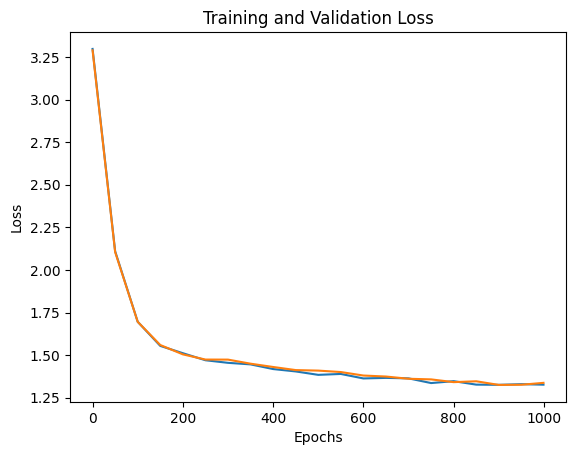

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from matplotlib.pylab import plt

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 50
learning_rate = 5e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 50
n_embd = 8
n_head = 8
n_layer = 8
dropout = 0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

trainloss={}
valloss={}

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trainloss[iter] = losses['train']
        valloss[iter] = losses['val']
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))
print(trainloss)
 
# Plot and label the training and validation loss values
plt.plot(trainloss.keys(), trainloss.values(), label='Training Loss')
plt.plot(valloss.keys(), valloss.values(), label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 

In [ ]:
torch.save(model.state_dict(), "./chessgpt.pt")
!ls -lart

total 8648
drwxr-xr-x 4 root root    4096 Apr 25 13:33 .config
drwxr-xr-x 1 root root    4096 Apr 25 13:34 sample_data
drwxr-xr-x 1 root root    4096 Apr 27 09:41 ..
-rw-r--r-- 1 root root 1000001 Apr 27 09:41 raw.pgn.zst
-rw-r--r-- 1 root root 6815744 Apr 27 09:41 all.txt
-rw-r--r-- 1 root root  804797 Apr 27 09:41 input.txt
drwxr-xr-x 1 root root    4096 Apr 27 09:44 .
-rw-r--r-- 1 root root  210541 Apr 27 09:44 chessgpt.pt


In [ ]:
from google.colab import files
files.download('./chessgpt.onnx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install onnx
import onnx
torch.onnx.export(model, context, "chessgpt.onnx", verbose=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 39.1 MB/s eta 0:00:00
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
print(torch.__version__)
!ls -lart

2.0.0+cu118
total 12468
drwxr-xr-x 4 root root    4096 Apr 25 13:33 .config
drwxr-xr-x 1 root root    4096 Apr 25 13:34 sample_data
drwxr-xr-x 1 root root    4096 Apr 27 09:41 ..
-rw-r--r-- 1 root root 1000001 Apr 27 09:41 raw.pgn.zst
-rw-r--r-- 1 root root 6815744 Apr 27 09:41 all.txt
-rw-r--r-- 1 root root  804797 Apr 27 09:41 input.txt
-rw-r--r-- 1 root root  210541 Apr 27 09:44 chessgpt.pt
-rw-r--r-- 1 root root 3911551 Apr 27 10:17 chessgpt.onnx
drwxr-xr-x 1 root root    4096 Apr 27 10:17 .


In [ ]:
loadedModel = BigramLanguageModel()
loadedModel.load_state_dict(torch.load("./s.txt"))
loadedModel.eval()

# generate from the model
loadedm = loadedModel.to(device)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(loadedm.generate(context, max_new_tokens=100)[0].tolist()))



f5 Nd7 Qxd6 Qf3 c4 Ne6 exb2 e4 Bxc4 cxb6 Be4 Rxg5 Qxd2+ Kxg1 Ra3 Bxa6+ Ra2 Ke4 h3 0-1
e5 Bf3 d4?Qxc7


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))



xe4 dxe6 Bxd3 e6 Nxd4 Bxf3 d5 Bxg5 g4 dxg5 fxf2 cxd5 axd6 Nxc7+ Qxf5 Qb3 Nf7 Rxg8 Be4 Rdebc8-O Ba5 Q
